## Análisis Diagnóstico: Árbol de decisión de aprobación de proveedores 

El análisis de árbol de decisión es una técnica de modelado de datos que se utiliza para clasificar y predecir valores. Consiste en la creación de un árbol de decisiones donde cada nodo representa una pregunta sobre las características de los datos y las ramas representan las posibles respuestas a esa pregunta. En cada nodo, se selecciona la característica que mejor separa los datos y se divide el conjunto de datos en dos grupos, uno para cada respuesta posible. El proceso se repite recursivamente en cada uno de los subgrupos hasta que se alcanza un nivel de pureza deseado en las hojas del árbol.

En el contexto de la predicción de la aprobación de proveedores, el análisis de árbol de decisión se utiliza para construir un modelo que clasifica a los proveedores en "aprobados" o "no aprobados" en función de las características que se utilizan como entrada en el modelo. Las características pueden incluir, por ejemplo, la cantidad promedio de productos que el proveedor entrega, el tiempo promedio de entrega, la calidad de los productos entregados, entre otros.

Una vez que se ha entrenado el modelo con un conjunto de datos de entrenamiento, se puede utilizar para predecir la aprobación de nuevos proveedores. El modelo clasificará al nuevo proveedor como "aprobado" o "no aprobado" en función de sus características, lo que permite tomar decisiones informadas sobre si trabajar con ese proveedor o no. El análisis de árbol de decisión es una técnica de modelado poderosa y flexible que se utiliza ampliamente en el análisis de datos y la toma de decisiones en una variedad de campos.

### Carga de librerías de python necesarias

Las librerías de Python son conjuntos de código predefinido que se utilizan para realizar tareas específicas en el lenguaje de programación Python.
Las librerías se utilizan para diferentes propósitos, como manipulación de datos, análisis de datos, visualización de datos, aprendizaje automático, desarrollo web, entre otros. 

In [1]:
import pyodbc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn import metrics

plt.rcParams['figure.figsize'] = [12, 8]

import warnings
warnings.filterwarnings('ignore')

### Extracción de datos desde SQL Server

In [2]:
# Crea una conexión con la base de datos
cnx = pyodbc.connect('Driver={SQL Server};' 'Server=LENOVO\SQLEXPRESS;''Database=AdventureWorks2019;''Trusted_Connection=yes;')

# Ejecuta la consulta y guarda los resultados en un DataFrame
data = pd.read_sql('''SELECT 
	t3.Name as 'proveedor',
	SUM(t2.OrderQty) / COUNT( DISTINCT T1.PurchaseOrderID) as 'cantidad_promedio',
	AVG(DATEDIFF(day, t1.OrderDate, t1.ShipDate)) as 'tiempo_promedio',
	SUM(t2.ReceivedQty)/ SUM(t2.OrderQty)  as 'calidad',
	CASE 
		WHEN SUM(t2.ReceivedQty)/ SUM(t2.OrderQty) > 0.99 THEN 'Si'
		WHEN SUM(t2.ReceivedQty)/ SUM(t2.OrderQty) > 1 THEN 'No'
		ELSE 'No' 
	END as 'aprobado'
FROM Purchasing.PurchaseOrderHeader as t1
	INNER JOIN Purchasing.PurchaseOrderDetail as t2 ON t1.PurchaseOrderID = t2.PurchaseOrderID
	INNER JOIN Purchasing.Vendor AS T3 ON t1.VendorID = t3.BusinessEntityID
	GROUP BY t3.Name''', con=cnx)

#### Exploración inicial de los datos

Se presentan las dimensiones y las variables que componen el dataset las cuales están relacionadas con información de Proveedores.

In [3]:
data.shape

(86, 5)

In [4]:
data.columns

Index(['proveedor', 'cantidad_promedio', 'tiempo_promedio', 'calidad',
       'aprobado'],
      dtype='object')

In [5]:
data.head()

,proveedor,cantidad_promedio,tiempo_promedio,calidad,aprobado
0,Electronic Bike Repair & Supplies,1315,9,0.991058,Si
1,Bergeron Off-Roads,16,9,1.000000,Si
2,Expert Bike Co,655,9,1.000000,Si
3,Inner City Bikes,11,9,1.000000,Si
4,Vista Road Bikes,1100,9,0.992072,Si


### Procesamiento de los datos

#### Dividir los datos en un conjunto de entrenamiento y un conjunto de prueba

In [6]:
X_train, X_test, y_train, y_test = train_test_split(data[['cantidad_promedio', 'tiempo_promedio', 'calidad']], data['aprobado'], test_size=0.3, random_state=0)

#### Crear una instancia del árbol de decisión

In [7]:
clf = DecisionTreeClassifier(criterion='entropy')

#### Entrenar el modelo

In [8]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy')

### Realizar predicciones en el conjunto de prueba

In [9]:
y_pred = clf.predict(X_test)

#### Calcular la precisión del modelo

In [10]:
acc = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:", acc)

Accuracy: 1.0


#### Crear una matriz de confusión

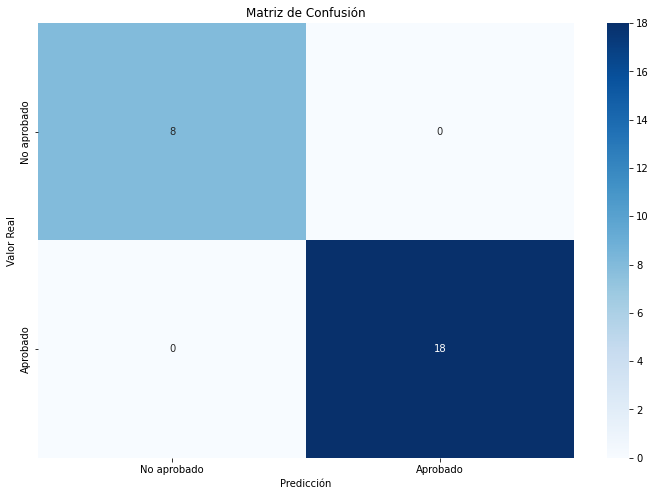

In [11]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=["No aprobado", "Aprobado"], yticklabels=["No aprobado", "Aprobado"])
plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.title("Matriz de Confusión")
plt.show()

#### Impresión del árbol de decisión

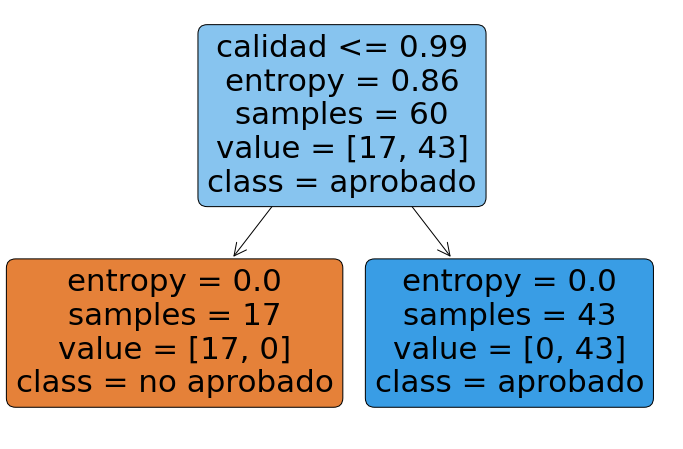

In [12]:
fig, ax = plt.subplots()
plot_tree(clf, feature_names=['cantidad_promedio', 'tiempo_promedio', 'calidad'], class_names=['no aprobado','aprobado'], filled=True, rounded=True, ax=ax)
plt.show()

### Predicción de un nuevo proveedor

In [13]:
new_supplier = [[500, 15, 0.87]]

# Realizar una predicción para el nuevo proveedor
new_supplier_pred = clf.predict(new_supplier)

# Imprimir la predicción
if new_supplier_pred == ['Si']:
    print("Predicción para el nuevo Proveedor: aprobado")
else:
    print("Predicción para el nuevo Proveedor: no aprobado")

Predicción para el nuevo Proveedor: no aprobado


## Conclusiones

Basados en el modelo construido utilizando el análisis de árbol de decisión, se pueden obtener varias conclusiones que pueden ser útiles para la empresa **AdventureWorks** en la toma de decisiones en relación a sus proveedores:

* La cantidad promedio de productos que entrega un proveedor parece ser el factor más importante para determinar si un proveedor es aprobado o no. Los proveedores que entregan grandes cantidades de productos tienen más probabilidades de ser aprobados.

* El tiempo promedio de entrega es también un factor importante. Los proveedores que entregan los productos más rápido tienen más probabilidades de ser aprobados.

* La calidad de los productos entregados es importante para la aprobación de un proveedor. Si la calidad es baja, es menos probable que un proveedor sea aprobado.

* Basándonos en el modelo construido, un proveedor que entrega menos de 366 productos en promedio, tiene un tiempo promedio de entrega de más de 5.5 días y una tasa de calidad inferior al 99% probablemente no será aprobado.

En resumen, el modelo indica que la cantidad promedio de productos, el tiempo promedio de entrega y la calidad de los productos entregados son los factores clave que influyen en la decisión de aprobar o no a un proveedor. La empresa puede utilizar esta información para evaluar a sus proveedores y tomar decisiones informadas sobre con quiénes trabajar.

## Recomendaciones

A partir de las conclusiones obtenidas del análisis de árbol de decisión, se pueden ofrecer varias recomendaciones a la empresa para mejorar su proceso de selección y gestión de proveedores:

* La empresa puede considerar establecer requisitos mínimos para la cantidad promedio de productos entregados, el tiempo promedio de entrega y la tasa de calidad de los productos entregados para los proveedores. Esto permitiría establecer estándares claros para la selección y gestión de proveedores.

* Es importante que la empresa tenga en cuenta los factores más importantes en la toma de decisiones en relación a la aprobación de los proveedores, es decir, la cantidad promedio de productos, el tiempo promedio de entrega y la calidad de los productos entregados. Estos factores pueden ser considerados en la evaluación de nuevos proveedores y en la gestión de los actuales.

* La empresa puede utilizar el modelo construido para hacer predicciones sobre la aprobación o no aprobación de nuevos proveedores en base a sus datos de cantidad promedio de productos entregados, tiempo promedio de entrega y tasa de calidad. Esto permitiría tomar decisiones informadas y precisas en cuanto a la selección de proveedores.

* La empresa puede considerar la realización de auditorías y evaluaciones regulares a los proveedores para garantizar que cumplan con los requisitos mínimos establecidos en cuanto a la cantidad promedio de productos, tiempo promedio de entrega y calidad de los productos entregados.

En resumen, la empresa puede mejorar su proceso de selección y gestión de proveedores al establecer requisitos mínimos claros, tomar en cuenta los factores más importantes, utilizar el modelo construido para hacer predicciones y realizar evaluaciones regulares y auditorías. Esto permitiría a la empresa trabajar con proveedores más confiables y reducir el riesgo de retrasos, defectos de calidad y otros problemas.